In [2]:
!pip uninstall -y numpy
!pip uninstall -y thinc

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: thinc 8.3.4
Uninstalling thinc-8.3.4:
  Successfully uninstalled thinc-8.3.4


In [3]:
!pip install numpy==1.26.4
!pip install --no-deps top2vec
!pip install --no-deps pandas scikit-learn hdbscan gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 75.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import joblib
from tqdm.notebook import tqdm
import pickle
import string
import random
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.spatial.distance import cosine
from top2vec import Top2Vec
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy.rec'

In [ ]:
# Download L'éducation sentimentale and Vingt mille lieux sous les mers on your drive
!gdown 1A6P3_YVUo-DYDbpAn_RDA4pRFydI-4ju
!gdown 1ZtOZ7UewZaR-XUSH01W2CDfrc6v8EU-s

Downloading...
From: https://drive.google.com/uc?id=1A6P3_YVUo-DYDbpAn_RDA4pRFydI-4ju
To: /content/1870_Verne-Jules_Vingt-mille-lieues-sous-les-mers.txt
100% 912k/912k [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZtOZ7UewZaR-XUSH01W2CDfrc6v8EU-s
To: /content/1869_Flaubert-Gustave_L-Education-sentimentale.txt
100% 1.00M/1.00M [00:00<00:00, 47.1MB/s]


In [ ]:
!gdown 19hKfMl2bmC4jbb0eptLd1cOtx-q22TrO # Download D2V model

Downloading...
From (original): https://drive.google.com/uc?id=19hKfMl2bmC4jbb0eptLd1cOtx-q22TrO
From (redirected): https://drive.google.com/uc?id=19hKfMl2bmC4jbb0eptLd1cOtx-q22TrO&confirm=t&uuid=4889de38-28ac-4dfe-9ddb-20d6f6375982
To: /content/doc2vec_model_novels_large.pkl
100% 315M/315M [00:04<00:00, 66.3MB/s]


In [ ]:
doc2vec_model = pickle.load(open('doc2vec_model_novels_large.pkl','rb'))

In [ ]:
def read_and_chunk_text(path_to_txt, chunk_size=256, overlap=64):
    with open(path_to_txt, 'r', encoding='utf-8') as f:
        text = f.read()

    # Tokenize the text by splitting on whitespace
    tokens = text.split()

    # Create rolling chunks
    chunks = []
    for i in range(0, len(tokens), chunk_size - overlap):
        chunk = tokens[i:i + chunk_size]
        if len(chunk) == chunk_size:
            chunks.append(chunk)

    return chunks

In [ ]:
def infer_vectors_from_chunks(path_to_txt, model, chunk_size=256, overlap=64):
    # Get rolling chunks from the text
    chunks = read_and_chunk_text(path_to_txt, chunk_size, overlap)

    # Infer vector for each chunk
    vectors = []
    for chunk in tqdm(chunks, desc="Inferring vectors"):
        inferred_vector = model.infer_vector(chunk)
        vectors.append(inferred_vector)

    return vectors, chunks

In [ ]:
vecteurs_D2V, chunks = infer_vectors_from_chunks("1869_Flaubert-Gustave_L-Education-sentimentale.txt", doc2vec_model)

Inferring vectors:   0%|          | 0/811 [00:00<?, ?it/s]

In [ ]:
doc_labels = [f"chunk_{i}" for i in range(len(vecteurs_D2V))]

In [ ]:
chunks_as_strings = [" ".join(chunk) for chunk in chunks]

In [ ]:
chunks_as_strings[0]

'Le 15 septembre 1840, vers six heures du matin, la Ville-de-Montereau, près de partir, fumait à gros tourbillons devant le quai Saint-Bernard.Des gens arrivaient hors d’haleine ; des barriques, des câbles, des corbeilles de linge gênaient la circulation ; les matelots ne répondaient à personne ; on se heurtait ; les colis montaient entre les deux tambours, et le tapage s’absorbait dans le bruissement de la vapeur, qui, s’échappant par des plaques de tôle, enveloppait tout d’une nuée blanchâtre, tandis que la cloche, à l’avant, tintait sans discontinuer.Enfin le navire partit ; et les deux berges, peuplées de magasins, de chantiers et d’usines, filèrent comme deux larges rubans que l’on déroule.Un jeune homme de dix-huit ans, à longs cheveux et qui tenait un album sous son bras, restait auprès du gouvernail, immobile. À travers le brouillard, il contemplait des clochers, des édifices dont il ne savait pas les noms ; puis il embrassa, dans un dernier coup d’œil, l’île Saint-Louis, la Ci

In [ ]:
model_T2V = Top2Vec(
    documents=chunks_as_strings,
    min_count=10,
    embedding_model='doc2vec',
    embedding_model_path="doc2vec_model_novels_large.pkl",
    document_ids=doc_labels,
    umap_args={'n_neighbors': 10, 'n_components': 5, 'metric': 'cosine'},
    hdbscan_args={'min_cluster_size': 10, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'cluster_selection_epsilon': 0.1},
    speed="learn",
    workers=4
)

2025-04-09 17:33:08,124 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2025-04-09 17:33:08,605 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-09 17:33:41,140 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-09 17:34:08,045 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:1

In [ ]:
n = model_T2V.get_num_topics()
n

10

In [ ]:
for i in range(n):
    model_T2V.generate_topic_wordcloud(i)

Output hidden; open in https://colab.research.google.com to view.

# min count = 10

In [ ]:
model_T2V = Top2Vec(
    documents=chunks_as_strings,
    min_count=10,
    embedding_model='distiluse-base-multilingual-cased',
    #embedding_model_path="/content/drive/MyDrive/TAL_ENC/models/D2V_model.model",
    document_ids=doc_labels,
    umap_args={'n_neighbors': 5, 'n_components': 5, 'metric': 'cosine'},
    hdbscan_args={'min_cluster_size': 5, 'metric': 'euclidean', 'cluster_selection_method': 'eom'},
    speed="learn",
    workers=4
)

2025-04-09 17:37:08,147 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-04-09 17:37:08,743 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2025-04-09 17:37:29,456 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-09 17:40:21,983 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-09 17:40:23,402 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04

In [ ]:
n = model_T2V.get_num_topics()
n

23

In [ ]:
for i in range(n):
    model_T2V.generate_topic_wordcloud(i)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model_T2V.save("/content/drive/MyDrive/TAL_ENC/models/T2V_model.model")

In [ ]:
model_T2V = Top2Vec.load("/content/drive/MyDrive/TAL_ENC/models/T2V_model.model")

In [ ]:
doc_ids = model_T2V.document_ids

In [ ]:
document_topics_info = model_T2V.get_documents_topics(doc_ids)

In [ ]:
document_topics_info[2]

array([['descendait', 'agissait', 'tournait', ..., 'pont', 'francais',
        'distinguait'],
       ['recevait', 'fonds', 'envoyait', ..., 'martin', 'avaient',
        'proprietaire'],
       ['agissait', 'paraissait', 'contenait', ..., 'aurait', 'ces',
        'ce'],
       ...,
       ['recevait', 'envoyait', 'arnoux', ..., 'reprit', 'dont',
        'disait'],
       ['clerc', 'doctrines', 'croyant', ..., 'opposition', 'politique',
        'pas'],
       ['agissait', 'paraissait', 'contenait', ..., 'aurait', 'ces',
        'ce']], dtype='<U14')

In [ ]:
def plot_topic_relevance(array_info, topic_number, topic_name, window_size=8):
    # Extract relevance scores for the specified topic across all chunks
    topic_relevance_amour = [scores[3] for scores in array_info[3]]
    topic_relevance_emeute = [scores[5] for scores in array_info[3]]

    # Apply a rolling window average to smooth the relevance scores
    smoothed_relevance_amour = np.convolve(topic_relevance_amour, np.ones(window_size) / window_size, mode='valid')
    smoothed_relevance_emeute = np.convolve(topic_relevance_emeute, np.ones(window_size) / window_size, mode='valid')

    # Plot the smoothed topic relevance over the novel's progression
    plt.plot(range(len(smoothed_relevance_amour)), smoothed_relevance_amour, label=f"Topic {3}: Amour")
    plt.plot(range(len(smoothed_relevance_emeute)), smoothed_relevance_emeute, label=f"Topic {5}: Émeute")
    plt.xlabel("Chunk Number")
    plt.ylabel("Topic Relevance (Smoothed)")
    plt.legend()
    plt.show()
    return topic_relevance_amour, topic_relevance_emeute

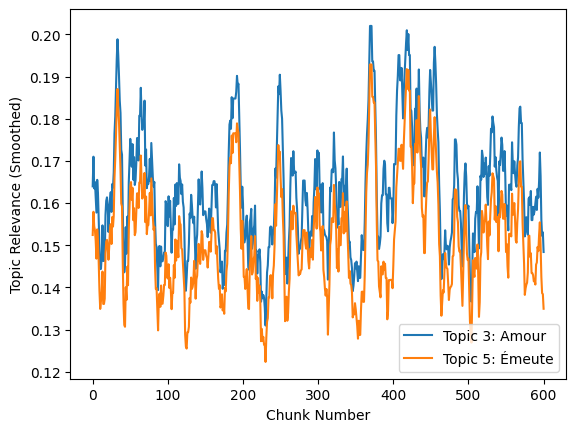

In [ ]:
topic = plot_topic_relevance(document_topics_info, 21, "Amour")

In [ ]:
for i, valeur in enumerate(topic):
    if valeur > 0.53:
        print(i)

172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [ ]:
chunks_as_strings[179]

'parcoururent avidement l’horizon.Dans le nord-est émergeaient deux îles volcaniques d’inégale grandeur, entourées d’un récif de coraux qui mesurait quarante milles de circuit. Nous étions en présence de l’île de Vanikoro proprement dite, à laquelle Dumont d’Urville imposa le nom d’île de la Recherche, et précisément devant le petit havre de Vanou, situé par 16°4’ de latitude sud, et 164°32’ de longitude est. Les terres semblaient recouvertes de verdure depuis la plage jusqu’aux sommets de l’intérieur, que dominait le mont Kapogo, haut de quatre cent soixante-seize toises.Le Nautilus, après avoir franchi la ceinture extérieure de roches par une étroite passe, se trouva en dedans des brisants, où la mer avait une profondeur de trente à quarante brasses. Sous le verdoyant ombrage des palétuviers, j’aperçus quelques sauvages qui montrèrent une extrême surprise à notre approche. Dans ce long corps noirâtre, s’avançant à fleur d’eau, ne voyaient-ils pas quelque cétacé formidable dont ils de